# Testing and Training Model

### This notebook takes the cleaned dataset (log_cleaned.csv) to train and test the model.  It then calculates mean absolute error and R² to determine how well the model is able to predict flight times.

## Step 1: Load Dependencies

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

## Step 2: Load Data

This step loads the data in the csv file and makes all of the column headings lower case.  There were several errors when using sentence case headings, so this eliminates that problem.

In [2]:
df = pd.read_csv("log_cleaned.csv")
df.columns = df.columns.str.strip().str.lower()

## Step 3: Conversion of times to Minutes 

This step coverts the raw data for the duration from hours and minutes into minutes. 

In [3]:
# Convert 'duration' from "H:MM" to minutes
def duration_to_minutes(duration_str):
    try:
        h, m = map(int, duration_str.strip().split(':'))
        return h * 60 + m
    except:
        return np.nan

df['duration'] = df['duration'].apply(duration_to_minutes)
df = df.dropna(subset=['duration'])

df['depminuteofday'] = (
    pd.to_datetime(df['dep time'], format='%H:%M', errors='coerce').dt.hour * 60 +
    pd.to_datetime(df['dep time'], format='%H:%M', errors='coerce').dt.minute
)
df = df.dropna(subset=['depminuteofday'])

## Step 4: Encode Data

In [4]:
categorical_cols = ['from iata code', 'to iata code', 'aircraft']
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))

X = pd.concat([df[['distance', 'depminuteofday']].reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)
y = df['duration']

## Step 5:  Train Test Split

This separates the data into train (80%) and test (20%).

In [5]:
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, df.index, test_size=0.2, random_state=42
)

## Step 6:  Random Forest Prediction

This step uses the RandomForestRegressor to train the model and then predict times.  It calculates and displays the MAE and R-squared

In [6]:
# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f} minutes")
print(f"R² Score: {r2:.2f}")

Mean Absolute Error: 5.66 minutes
R² Score: 0.96


## Step 6: Sample of Predictions with Errors

This step shows 10 of the predictions to gauge how close the predictions are to actual.

In [7]:
# Results table with route info
results_df = pd.DataFrame({
    'From': df.loc[idx_test, 'from iata code'].values,
    'To': df.loc[idx_test, 'to iata code'].values,
    'Distance': df.loc[idx_test, 'distance'].values,
    'Actual Duration': y_test.values,
    'Predicted Duration': y_pred
})
results_df['Absolute Error'] = (results_df['Actual Duration'] - results_df['Predicted Duration']).abs()
results_df = results_df.round(2)

print("\nSample of predictions:")
print(results_df.head(10))


Sample of predictions:
  From   To  Distance  Actual Duration  Predicted Duration  Absolute Error
0  SJC  ORD      1827              212              220.17            8.17
1  MDW  ISP       764               97              112.21           15.21
2  MSP  ORD       334               50               54.19            4.19
3  LSE  ORD       215               40               47.00            7.00
4  MDW  MEM       482               76               73.62            2.38
5  DEN  ORD       887              110              111.80            1.80
6  ORD  MCI       402               71               60.77           10.23
7  LAX  ORD      1743              190              203.75           13.75
8  DCA  ORD       611               98               98.52            0.52
9  MDW  MSY       828              114              112.37            1.63


## Step 7: Visualization

This step shows a visualization of the data against actual times.

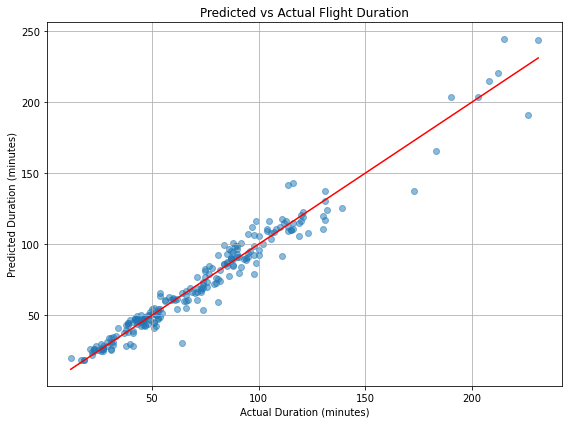

In [8]:
# Plot predictions vs. actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Duration (minutes)")
plt.ylabel("Predicted Duration (minutes)")
plt.title("Predicted vs Actual Flight Duration")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.grid(True)
plt.tight_layout()
plt.show()

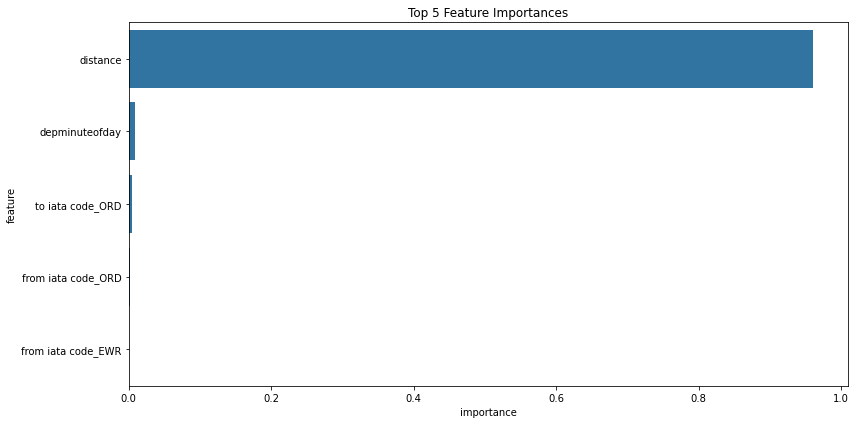

In [9]:
# Feature importance plot
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(5))
plt.title("Top 5 Feature Importances")
plt.tight_layout()
plt.show()

In [10]:
importances = model.feature_importances_
feature_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df.sort_values(by='Importance', ascending=False).head(5)

,Feature,Importance
0,distance,0.961004
1,depminuteofday,0.008551
233,to iata code_ORD,0.004812
98,from iata code_ORD,0.001616
43,from iata code_EWR,0.001216


## Step 8: MAE by Distance

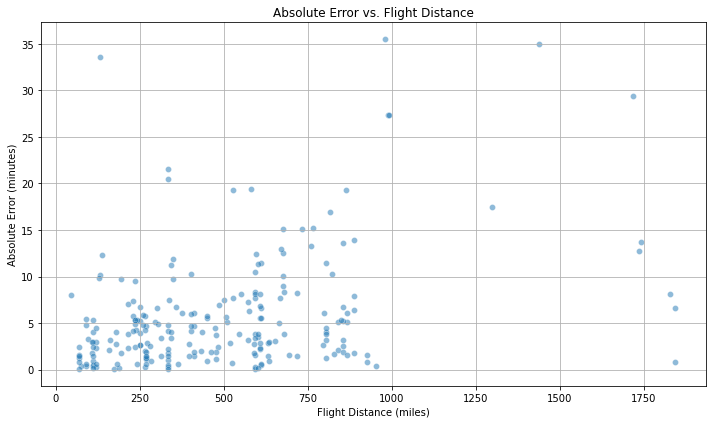

In [13]:
# Bin distances into ranges
bins = [0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2500]
labels = ['0–250', '251–500', '501–750', '751–1000', '1001–1250',
          '1251–1500', '1501–1750', '1751–2000', '2001–2500']
results_df["Distance Bin"] = pd.cut(results_df["Distance"], bins=bins, labels=labels)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x="Distance", y="Absolute Error", alpha=0.5)
plt.title("Absolute Error vs. Flight Distance")
plt.xlabel("Flight Distance (miles)")
plt.ylabel("Absolute Error (minutes)")
plt.grid(True)
plt.tight_layout()
plt.show()